In [1]:
from quantumnet.components import Network, Host, Controller
from quantumnet.components import ServerNode, ClientNode, RegularNode
from quantumnet.objects import Qubit, Logger
from quantumnet.components.simulation import QML_classifier,QNodeWrapper
from quantumnet.components.simulation import setup_model, train_model, input_dim, num_classes, num_layers, num_qubits
import pennylane as qml
from pennylane import numpy as np
import torch
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
import random


In [2]:
# rede = Network()
# controlador = Controller(rede)

# # Configura uma grade 4x4
# #13,8,2,6,0,3,11,15
# clients = [13]
# server = 10
# rede.set_topology_for_slices(graph_type='grade', dimensions=(4, 4), clients=clients, server=server)


# rede.draw()

# # Executa a simulação de slices
# rede.run_slice_simulation(clients=clients, server=server)
# Logger.activate(Logger)

In [3]:
# # **Definições do Circuito Quântico**
# num_qubits = 8  # Número de qubits usados no protocolo
# num_camadas = 32  # Profundidade do circuito (camadas)

# # Criando a instância do modelo quântico
# modelo_qml = ClassificadorQML(dim_entrada=256, dim_saida=4, num_qubits=num_qubits, num_camadas=num_camadas)

# # **Gerando o circuito do modelo e convertendo para Qiskit**
# circuito_quantico = modelo_qml.gerar_qiskit_circuit()

# # **Executando a Aplicação na Rede**
# rede.application_layer.run_app(
#     "AC_BQC",
#     alice_id=6,
#     bob_id=0,
#     num_qubits=num_qubits,
#     scenario=2,
#     circuit_depth=num_camadas,  # Número de camadas como profundidade do circuito
#     circuit_data=circuito_quantico  # Passando o circuito convertido
# )


In [4]:
# # Criando a instância do modelo quântico
# modelo_qml = ClassificadorQML(dim_entrada=256, dim_saida=4, num_qubits=8, num_camadas=32)

# # **Gerando o circuito do modelo e convertendo para Qiskit**
# circuito_quantico = modelo_qml.gerar_qiskit_circuit()
# circuito_quantico.draw()

# # Pegando o número correto de qubits e a profundidade do circuito
# num_qubits = modelo_qml.num_qubits  
# circuit_depth = modelo_qml.num_camadas  

# protocols = ["AC_BQC"]
# clients = [13]
# server = 10

# # Simulação de slices
# slice_paths_list = rede.run_slice_simulation(clients=clients, server=server)

# # Inicializa slices
# controlador.initialize_slices(
#     network=rede,
#     clients=clients,
#     server=server,
#     protocols=protocols,
#     slice_paths_list=slice_paths_list
# )

# # Criando 1 requisição com o circuito do modelo quântico
# num_requests = 1
# requests = []

# for i in range(num_requests):
#     client_index = i % len(clients)
#     alice_id = clients[client_index]
#     protocol = protocols[client_index]
#     slice_path = slice_paths_list[client_index]
#     bob_id = server

#     # **Agora passamos o circuito personalizado corretamente**
#     request = rede.generate_request_slice(
#         alice_id=alice_id,
#         bob_id=bob_id,
#         num_qubits=num_qubits,  
#         num_gates=None,  
#         protocol=protocol,
#         slice_path=slice_path,
#         scenario=2,
#         custom_circuit=circuito_quantico  
#     )
    
#     requests.append(request)

# # Agendamento de requisições
# scheduled_timeslots = controlador.schedule_requests(
#     requests=requests,
#     slice_paths=controlador.slices,
#     protocols=protocols
# )

# # Executa as requisições agendadas
# rede.execute_scheduled_requests(scheduled_timeslots, slice_paths=controlador.slices)


In [5]:
# rede = Network()
# controller = Controller(rede)
# rede.set_ready_topology('grade', 8, 4, 4, clients=[13,8,2,6,0,3,11,15], server=10)  
# rede.draw()

Hosts inicializados
Canais inicializados
Pares EPRs adicionados
Topologia configurada com sucesso para slices!


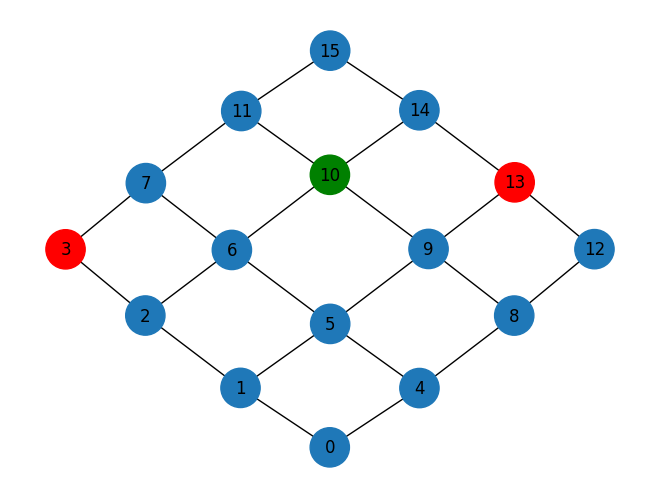

Final Slice Paths for 2 slices: [[13, 9, 10], [3, 2, 6, 10]]


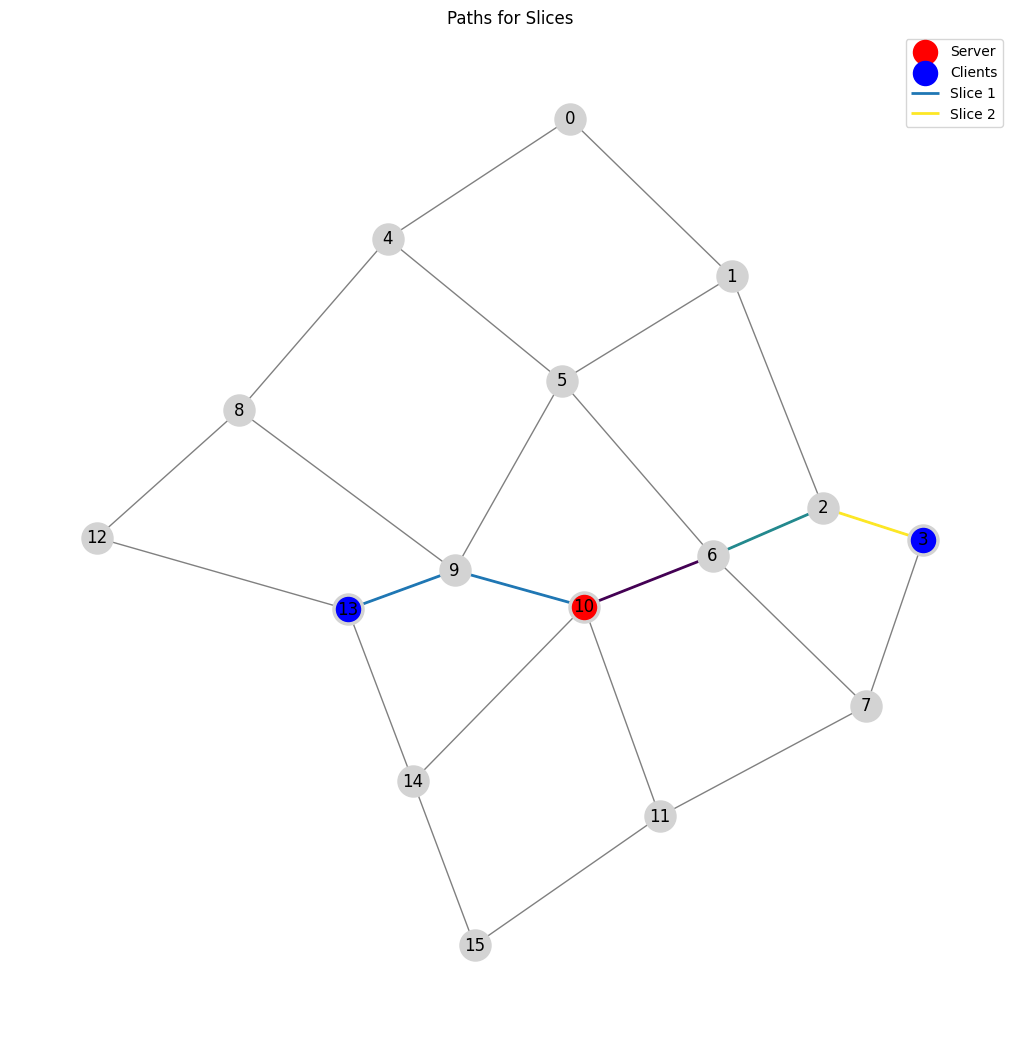

2025-02-17 10:49:54,862: Slice slice_1 configurado com cliente 13, servidor 10, protocolo AC_BQC e caminho [13, 9, 10].
2025-02-17 10:49:54,862: Slice slice_2 configurado com cliente 3, servidor 10, protocolo BFK_BQC e caminho [3, 2, 6, 10].


Using device: cpu


2025-02-17 10:49:54,920: Usando circuito personalizado com 8 qubits e profundidade 32.
2025-02-17 10:49:54,920: Requisição adicionada: Alice 13 -> Bob 10 com protocolo AC_BQC e cenário 2.
2025-02-17 10:49:56,351: Reiniciando a rede antes de processar o timeslot 1.
2025-02-17 10:49:56,355: Rede reiniciada com sucesso.
2025-02-17 10:49:56,355: Rede reiniciada. Timeslot atual: 1.
2025-02-17 10:49:56,355: Timeslot avançado para 1.
2025-02-17 10:49:56,355: Executando requisições do timeslot 1.
2025-02-17 10:49:56,355: Executando requisição: Alice 13 -> Bob 10, Protocolo: AC_BQC
2025-02-17 10:49:56,355: Slice Path fornecido: [13, 9, 10]
2025-02-17 10:49:56,355: Rota extraída para execução: [13, 9, 10]
2025-02-17 10:49:56,355: Timeslot 1: Iniciando protocolo Andrew Childs entre Alice 13 e Bob 10.
2025-02-17 10:49:56,355: Limpando a memória do cliente (Alice) antes de iniciar o protocolo.
2025-02-17 10:49:56,360: Limpando a memória do servidor (Bob) antes de iniciar o protocolo.
2025-02-17 10:

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 32


2025-02-17 10:49:56,546: Resultado da execução: executado
2025-02-17 10:49:56,547: Requisição {'alice_id': 13, 'bob_id': 10, 'num_qubits': 8, 'quantum_circuit': <__main__.QNodeWrapper object at 0x000001638A2D3410>, 'circuit_depth': 32, 'protocol': 'AC_BQC', 'slice_path': [13, 9, 10], 'scenario': 2, 'status': 'executado'} - Status: executado


Requisição executada com sucesso no timeslot 1!
Iniciando treinamento do modelo após a requisição no timeslot 1...
Epoch 1/4 - Loss: 1.3868, Acurácia: 0.2600
Epoch 2/4 - Loss: 1.3832, Acurácia: 0.2600
Epoch 3/4 - Loss: 1.3810, Acurácia: 0.2400
Epoch 4/4 - Loss: 1.3867, Acurácia: 0.2400
Processamento e treinamento concluídos com sucesso!


In [7]:
rede = Network()
controlador = Controller(rede)

clients = [13, 3]
server = 10
rede.set_topology_for_slices(graph_type='grade', dimensions=(4, 4), clients=clients, server=server)
rede.draw()


slice_paths_list = rede.run_slice_simulation(clients=clients, server=server)
Logger.activate(Logger)


protocols = ["AC_BQC", "BFK_BQC"]
controlador.initialize_slices(
    network=rede,
    clients=clients,
    server=server,
    protocols=protocols,
    slice_paths_list=slice_paths_list
)

# Configuração do Classificador Quântico

# Hiperparâmetros do classificador
input_dim = 256  #isso define a dimensão dos dados de entrada,tipo deve ter 256 elementos
num_classes = 4  #o número de classes ou categorias que o modelo deve classificar, uma saída com 4 valores
num_layers = 32  #quantidade de camadas do circuito quântico
num_qubits = 8         
num_reup = 3  #o número de vezes que o circuito é reexecutado ou outra estratégia específica de processamento 

# Configuração do dispositivo para execução (GPU, se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Definição do modelo quântico usando PennyLane e PyTorch
class QML_classifier(torch.nn.Module):
    def __init__(self, input_dim, output_dim, num_qubits, num_layers):
        super().__init__()
        torch.manual_seed(1337) # uma semente para que os números aleatórios sejam reprodutíveis.
        self.num_qubits = num_qubits
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        # Define o dispositivo para execução do circuito quântico
        self.device = qml.device("lightning.qubit", wires=self.num_qubits)
        
        # calcula a forma dos parâmetros (pesos) necessários para a camada quântica
        self.weights_shape = qml.StronglyEntanglingLayers.shape(
            n_layers=self.num_layers, n_wires=self.num_qubits
        )
        
        @qml.qnode(self.device, interface="torch") #Esse decorator transforma a função circuit em um QNode, que é o objeto que executa o circuito quântico no dispositivo definido acima
        def circuit(sample, weights, bias):#dados de entrada, pesos e bias(parametros treináveis)
            qml.StronglyEntanglingLayers(
                weights=weights * sample + bias, wires=range(self.num_qubits)
            )
            # lista com as expectativas da medição do operador PauliZ para cada qubit de saída, sendo que o valor de saída é a média dessas expectativas
            return [qml.expval(qml.PauliZ(i)) for i in range(self.output_dim)]
        
        self.qnode = circuit
        
        #Cria tensores aleatórios com a forma calculada para os pesos e bias , com requires_grad=True para que o PyTorch possa otimizar esses parâmetros durante o treinamento
        init_weights = 0.1 * torch.rand(self.weights_shape, requires_grad=True)
        init_bias = 0.1 * torch.rand(self.weights_shape, requires_grad=True)
        self.weights = torch.nn.Parameter(init_weights)
        self.bias = torch.nn.Parameter(init_bias) #Converte os tensores em parâmetros do modelo
    
    def forward(self, x):
        #Obtém o tamanho do batch (número de amostras) dos dados de entrada
        batch_size = x.shape[0]
        expected_elements = int(np.prod(self.weights_shape))  # Calcula o produto dos elementos da tupla weights_shape para determinar quantos elementos cada amostra precisa ter 
        
        # Ajusta cada amostra para ter exatamente expected_elements
        if x.shape[1] > expected_elements: 
            x = x[:, :expected_elements]
        elif x.shape[1] < expected_elements:
            repeat_factor = (expected_elements // x.shape[1]) + 1
            x = x.repeat(1, repeat_factor)[:, :expected_elements]
        
        outputs = []
        for i in range(batch_size): #Itera sobre cada amostra no batch. Para cada amostra, redimensiona o vetor de entrada para a forma dos pesos e executa o circuito quântico
            sample = x[i].reshape(self.weights_shape)
            output = self.qnode(sample, self.weights, self.bias)
            # Se o QNode retornar uma lista ou tupla, converte para tensor
            if isinstance(output, (list, tuple)):
                output = torch.stack(output)
            outputs.append(output)
        return torch.stack(outputs) #Após processar todas as amostras, empilha os resultados em um tensor final com a dimensão do batch.

# Inicializa o modelo e move para o dispositivo adequado
qml_model = QML_classifier(input_dim, num_classes, num_qubits, num_layers)
qml_model.to(device)

# Wrapper para encapsular o QNode e permitir acesso à profundidade do circuito
class QNodeWrapper: #serve para encapsular o QNode do classificador,fornece um método depth() que retorna a profundidade efetiva do circuito
    def __init__(self, qnode, depth):
        self.qnode = qnode
        self._depth = depth

    def depth(self):
        return self._depth

custom_qc = QNodeWrapper(qml_model.qnode, num_layers)

# Gera requisições para a rede
num_requests = 1
requests = []

for i in range(num_requests):
    client_index = i % len(clients)  # Alterna entre os clientes
    alice_id = clients[client_index]
    protocol = protocols[client_index]
    slice_path = slice_paths_list[client_index]
    bob_id = server

    # Gera a requisição com os parâmetros definidos
    request = rede.generate_request_slice(
         alice_id=alice_id,
         bob_id=bob_id,
         num_qubits=num_qubits,      # 8 qubits
         num_gates=num_layers,       # 32 camadas
         protocol=protocol,
         slice_path=slice_path,
         scenario=2,
         custom_circuit=custom_qc   # Usa o circuito customizado via wrapper
    )
    requests.append(request)

# Agenda os tempos para as requisições (retorna um dicionário: timeslot -> lista de requisições)
scheduled_timeslots = controlador.schedule_requests(
    requests=requests,
    slice_paths=controlador.slices,
    protocols=protocols
)

# Treinamento

# Hiperparâmetros de treinamento
learning_rate = 0.1 # determina o tamanho dos passos dados durante a atualização dos pesos do modelo
epochs = 4  #corresponde a uma passagem completa por todo o conjunto de dados de treinamento
batch_size = 20 #o batch size é o número de amostras que serão processadas antes de atualizar os pesos do modelo

# Dados fictícios para treinamento (substitua pelos seus dados, se necessário)
X_train = torch.rand(200, input_dim).to(device) # entrada para o treinamento. 
Y_train = torch.randint(0, num_classes, (200,)).to(device) #estes representam os rótulos (labels) para cada amostra de treinamento
X_test = torch.rand(50, input_dim).to(device) # tensores para o conjjunto teste cada um 50 amostras
Y_test = torch.randint(0, num_classes, (50,)).to(device)

loss_fn = torch.nn.CrossEntropyLoss() #Define a função de perda
optimizer = torch.optim.Adam(qml_model.parameters(), lr=learning_rate)  #Cria um otimizador do tipo Adam para ajustar os parâmetros do modelo

def accuracy(labels, predictions): # Função de acurácia para calcular a proporção de previsões corretas
    correct = sum(torch.argmax(p) == l for l, p in zip(labels, predictions)) 
    return correct / len(labels) 

def treinar_modelo(qml_model, X_train, Y_train, X_test, Y_test, loss_fn, optimizer, epochs):
    for epoch in range(epochs):
        optimizer.zero_grad() #Zera os gradientes acumulados dos parâmetros do modelo
        outputs = qml_model(X_train)  #Executa uma passagem direta do modelo com o conjunto de treinamento
        batch_loss = loss_fn(outputs, Y_train) #Calcula a perda comparando as previsões do modelo com os rótulos verdadeiros usando a função de perda definida
        batch_loss.backward() #Realiza a retropropagação
        optimizer.step() #Atualiza os parâmetros do modelo de acordo com os gradientes calculados pelo otimizador
        
        with torch.no_grad(): #Desativa o cálculo de gradientes para as operações dentro do bloco
            predictions = qml_model(X_test) #Passa o conjunto de teste pelo modelo para obter as previsões.
            acc = accuracy(Y_test, predictions)
            print(f"Epoch {epoch+1}/{epochs} - Loss: {batch_loss.item():.4f}, Acurácia: {acc:.4f}")

# Processar as requsições e depois os treinamentos

def processar_requisicao(timeslot, req, qml_model, X_train, Y_train, X_test, Y_test, loss_fn, optimizer, epochs):
    # Cria um dicionário com o timeslot e apenas a requisição atual
    scheduled_requests = {timeslot: [req]}
    # Executa a requisição na rede usando os slice_paths definidos no controlador
    rede.execute_scheduled_requests(scheduled_requests, slice_paths=controlador.slices)
    print(f"Requisição executada com sucesso no timeslot {timeslot}!")
    # Após executar a requisição, inicia o treinamento do modelo
    print(f"Iniciando treinamento do modelo após a requisição no timeslot {timeslot}...")
    treinar_modelo(qml_model, X_train, Y_train, X_test, Y_test, loss_fn, optimizer, epochs)

# Itera sobre cada timeslot agendado e, dentro dele, sobre cada requisição individualmente
for timeslot, reqs in scheduled_timeslots.items():
    for req in reqs:
         processar_requisicao(timeslot, req, qml_model, X_train, Y_train, X_test, Y_test, loss_fn, optimizer, epochs)

print("Processamento e treinamento concluídos com sucesso!")
